In [3]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

from pycbc.detector import Detector

In [4]:
class SinusoidGenerator():
    ## Used to create sinusoid with different parameters to test biases
    ## Bias due to waveform frequency comes under spectral bias
    ## Bias due to signal duration comes under lack of proper inductive bias
    def __init__(self, 
                 A, 
                 phi, 
                 spectral_bias = False,
                 fixed_duration = 5.0,
                 lower_freq = 0.0,
                 upper_freq = 1024.0, 
                 duration_bias = False,
                 fixed_frequency = 100.0,
                 lower_tau = 0.1,
                 upper_tau = 12.0,
    ):
        # Sinusoidal wave parameters in general form
        self.A = A
        self.phi = phi
        # Spectral Bias (same duration, different frequencies)
        self.spectral_bias = spectral_bias
        self.fixed_duration = fixed_duration
        self.lower_freq = lower_freq
        self.upper_freq = upper_freq
        # Duration bias (same frequency, different durations)
        self.duration_bias = duration_bias
        self.fixed_frequency = fixed_frequency
        self.lower_tau = lower_tau
        self.upper_tau = upper_tau
    
    def generate(self, f, t):
        return self.A * np.sin(2.*np.pi*f*t + self.phi)

    def get_time_shift(self, detectors):
        # time shift signals based of detector choice
        ifo1, ifo2 = detectors
        dt = Detector(ifo1).light_travel_time_to_detector(Detector(ifo2))
        return dt
    
    def add_zero_padding(self, signal, start_time, sample_length, sample_rate):
        # if random duration less than sample_length, add zero padding
        duration = len(signal)/sample_rate
        left_pad = int(start_time * sample_rate)
        right_pad = int((sample_length - (start_time + duration)) * sample_rate)
        padded_signal = np.pad(signal, (left_pad, right_pad), 'constant', constant_values=(0, 0))
        return padded_signal

    def testing_spectral_bias(self, special):
        ## Generating sin waves with different frequencies but same duration
        # Params
        detectors = ('H1', 'L1')
        sample_length = 12.0 # seconds
        sample_rate = 2048. # Hz
        inj_low = 4.0
        inj_high = 5.0
        # Simulating bias
        random_freq = np.random.uniform(low=self.lower_freq, high=self.upper_freq)
        tseries = np.linspace(0.0, self.fixed_duration, int(self.fixed_duration*sample_rate))
        # Get time shift between detectors
        dt = self.get_time_shift(detectors)
        signal = self.generate(random_freq, tseries)
        start_time = np.random.uniform(inj_low, inj_high)
        signal_det1 = self.add_zero_padding(signal, start_time, sample_length, sample_rate)
        signal_det2 = self.add_zero_padding(signal, start_time+dt, sample_length, sample_rate)
        print(random_freq, start_time)
        return np.stack((signal_det1, signal_det2), axis=0)

    def testing_duration_bias(self, special):
        ## Generating sin waves with different duration but same frequency
        # Params
        detectors = ('H1', 'L1')
        sample_length = 12.0 # seconds
        sample_rate = 2048. # Hz
        inj_low = 4.0
        inj_high = 5.0
        # Simulating bias
        random_dur = np.random.uniform(low=self.lower_tau, high=self.upper_tau)
        tseries = np.linspace(0.0, random_dur, int(random_dur*sample_rate))
        # Get time shift between detectors
        dt = self.get_time_shift(detectors)
        signal = self.generate(self.fixed_frequency, tseries)
        start_time = np.random.uniform(inj_low, inj_high)
        signal_det1 = self.add_zero_padding(signal, start_time, sample_length, sample_rate)
        signal_det2 = self.add_zero_padding(signal, start_time+dt, sample_length, sample_rate)
        print(random_dur, start_time)
        return np.stack((signal_det1, signal_det2), axis=0)

    def apply(self, params: dict, special: dict):
        ## Generate sin waves for testing biased learning
        # Generate data based on required bias
        if self.spectral_bias:
            signals = self.testing_spectral_bias(special)
        elif self.duration_bias:
            signals = self.testing_duration_bias(special)
        return signals

In [5]:
gen = SinusoidGenerator(A=1e-20, 
                        phi=0.0, 
                        spectral_bias = True,
                        fixed_duration = 5.0,
                        lower_freq = 20.0,
                        upper_freq = 1024.0, 
                        duration_bias = False,
                        fixed_frequency = 100.0,
                        lower_tau = 0.1,
                        upper_tau = 12.0)

166.86549805393136 4.417162293393675


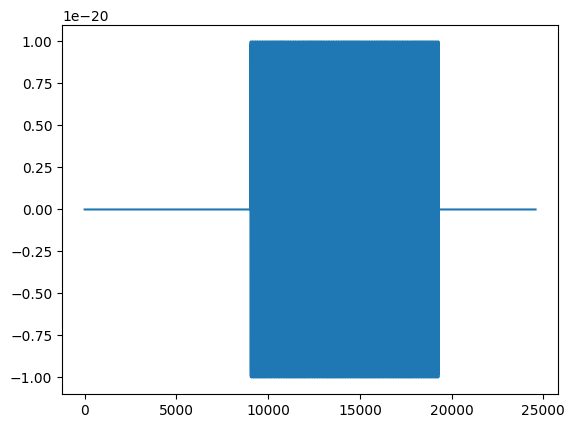

In [6]:
signals = gen.apply({}, {})
plt.plot(signals[0])

In [39]:
gen = SinusoidGenerator(A=1.0, 
                        phi=0.0, 
                        spectral_bias = False,
                        fixed_duration = 5.0,
                        lower_freq = 20.0,
                        upper_freq = 1024.0, 
                        duration_bias = True,
                        fixed_frequency = 100.0,
                        lower_tau = 0.1,
                        upper_tau = 5.0)

In [54]:
signals = gen.apply({}, {})

1.0293954981653537 4.727453695332725
